# Implementation of the EM algorithm for a mixture of gamma distributions.
## Author: Vadym Tunik.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import gamma, digamma
from scipy.optimize import fsolve

### Generating a mixture of M Gamma distributions

In [2]:
M = 2 # The number of mixture components.
sample_size = 10**6

In [3]:
def generate_random_params():
    """
    generates an array of parameters with weights in the first column, ketta parameter in the second, thetta parameter in the third

    return:
    params: np.array - (M, 3) array of weight- ketta- thetta parameters to the corresponding y_i cluster.
    """
    kettas = np.log(np.random.randint(3,20,M))
    thettas = np.random.randint(1,50,M)
    weights = np.random.rand(M)
    weights /= np.sum(weights)

    params = np.array([(weights[i], kettas[i], thettas[i]) for i in range(M)])
    return params

def show_params(params):
    """
    displays the mixture parameters on the screen.
    
    input:
    params: np.array - (M, 3) array of weight- alpha- thetta parameters to the corresponding y_i cluster.
    """
    weights = params [:,0]
    kettas =  params [:,1]
    thettas = params [:,2] 
    print(f'{weights=}')
    print(f"{kettas=}")
    print(f"{thettas=}")
    return weights, kettas, thettas


def gen_mixture(params):
    """
    generates data from a mixture of distributions with M mixture components.

    input:
    params: np.array - (M, 3) array of weight- ketta- thetta parameters to the corresponding y_i cluster.

    return:
    data_samples: np.array
    """
    weights = params [:,0]
    kettas =  params [:,1]
    thettas = params [:,2]

    data_samples = list()

    for i in range(M):
        new_samples = np.random.gamma(np.exp(kettas[i]), scale=thettas[i], size= int(weights[i]*sample_size))
        data_samples.extend(new_samples)

    return np.array(data_samples)


def show_mixture(X, params):
    """
    X: np.array - 
    params: np.array - (M, 3) array of weight- alpha- thetta parameters to the corresponding y_i cluster.
    """
    weights = params [:,0]
    kettas =  params [:,1]
    thettas = params [:,2]

    fig, ax = plt.subplots(figsize =(5,3))
    ax.hist(X , bins='auto', density=True)

    # build theoretical density
    x_min = X.min()
    x_max = X.max()
    x = np.linspace(x_min, x_max, sample_size)
    pdf = 0
    for i in range(M):
        pdf += weights[i] * stats.gamma.pdf(x, a=np.exp(kettas[i]), scale=thettas[i])
    ax.plot(x, pdf)

weights=array([0.5, 0.5])
kettas=array([1.60943791, 1.60943791])
thettas=array([ 8., 45.])


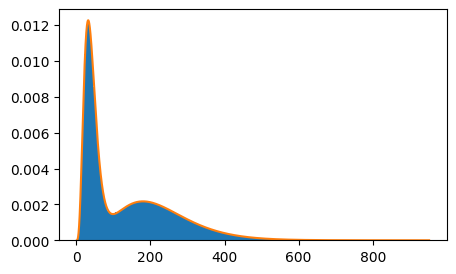

In [4]:
example_params = np.array([[ 0.5,  np.log(5) ,  8 ], [ 0.5,  np.log(5), 45 ]])
rand_params = generate_random_params()

# USE PARAMS: example_params or rand_params
used_params = example_params

show_params(used_params)
data = gen_mixture(used_params)
show_mixture(data, used_params)

In [5]:
data

array([ 19.54263895,  37.61740105,  50.82682464, ..., 301.15632701,
       307.77568785, 187.57337342])

### EM-algorithm

$y_i \in 1,...,M$ \
$y = (y_1,...,y_N)$

In [6]:
def p_l(x, ketta, thetta):
    exp_ketta = np.exp(ketta)
    return x**(exp_ketta-1) * np.exp(-x/thetta)   / gamma(exp_ketta) / thetta**exp_ketta


def e_step(X, M: int, params):
    """
    input:
    X: np.array - input X data.
    M: int - number of mixture components.
    params: np.array - (M, 3) array of weight-ketta-thetta parameters to the corresponding y_i cluster.

    return:
    Y: np.array - (N, M) array with probabilities that the n-th element belongs to the m-th cluster.
    """
    _Y = []

    for i in range(M):
        p_l_new = p_l(X, params[i][1], params[i][2])
        _Y.append(p_l_new)

    _Y = np.array(_Y)
    _Y /= _Y.sum(axis=0, keepdims=True)

    _Y = _Y.T
    return _Y

In [7]:
def ketta_equation(ketta, _p_l_sum, _p_l_sum_x_i, _p_l_sum_log_x_i):
    return (_p_l_sum_log_x_i / _p_l_sum) - np.log( _p_l_sum_x_i / _p_l_sum ) - digamma(np.exp(ketta)) + ketta

def m_step(_X, _Y, theta_g_params_initial):
    """
    input:
    X: np.array - input X data.
    Y: np.array - (N, M) array with probabilities that the n-th element belongs to the m-th cluster.
    theta_g_params_initial: np.array -  (M, 3) array of weight-alpha-thetta parameters to the corresponding y_i cluster; need for alpha params for fsolve.
    
    return:
    params_new: np.array - (M, 3) array with params to corresponding m-th cluster.
    """
    N, M = _Y.shape[0], _Y.shape[1]
    
    p_l_sum = _Y.sum(axis=0)
    p_l_sum_x_i = (_X * _Y.T).sum(axis=1)
    p_l_sum_log_x_i = (np.log(_X) * _Y.T).sum(axis=1)

    weights_new = p_l_sum / N
    ketta_new = fsolve(ketta_equation, theta_g_params_initial[:, 1], args=(p_l_sum, p_l_sum_x_i, p_l_sum_log_x_i))
    thetta_new = p_l_sum_x_i / p_l_sum / np.exp(ketta_new)
    
    params_new = np.array([(weights_new[i],ketta_new[i], thetta_new[i]) for i in range(M)])
    return params_new


In [8]:
def em_algo(X, max_iter=100, show_logs=False):
    """
    input:
    n_iterations: int - number of EM iterations to perform.

    return:
    theta_g_params: (M, 3) np.array - estimated parameters with the EM algorithm.
    """
    # let's initialize random params
    theta_g_weights = np.array([1/M for _ in range(M)])
    theta_g_kettas = np.random.randint(2,3,M)
    theta_g_thettas = np.random.randint(2,10,M)
    theta_g_params = np.array([(theta_g_weights[i],theta_g_kettas[i], theta_g_thettas[i]) for i in range(M)])

    for iter in range(max_iter):
        Y_0 = e_step(X, M, theta_g_params)
        theta_g_params_new = m_step(X, Y_0, theta_g_params)
        theta_g_params = theta_g_params_new
        if show_logs:
            print(f"{iter=}: weights = {theta_g_params[:,0]} kettas = {theta_g_params[:,1]} thettas = {theta_g_params[:,2]}")

    return theta_g_params


In [9]:
estim_params = em_algo(data, max_iter=100, show_logs=False) 

TRUE:
weights=array([0.5, 0.5])
kettas=array([1.60943791, 1.60943791])
thettas=array([ 8., 45.])
ESTIMATED:
weights=array([0.49952648, 0.50047352])
kettas=array([1.61018805, 1.60939332])
thettas=array([ 7.98358467, 44.94560554])


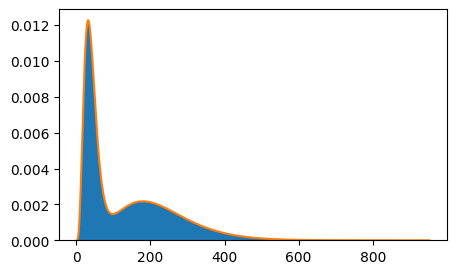

In [10]:
print("TRUE:")
weights_true, kettas_true, thettas_true = show_params(used_params)
print("ESTIMATED:")
weights_estim, kettas_estim, thettas_estim = show_params(estim_params)
show_mixture(data, estim_params)